# DLA PANA POLESIUKA (prawdziwe nie AI)

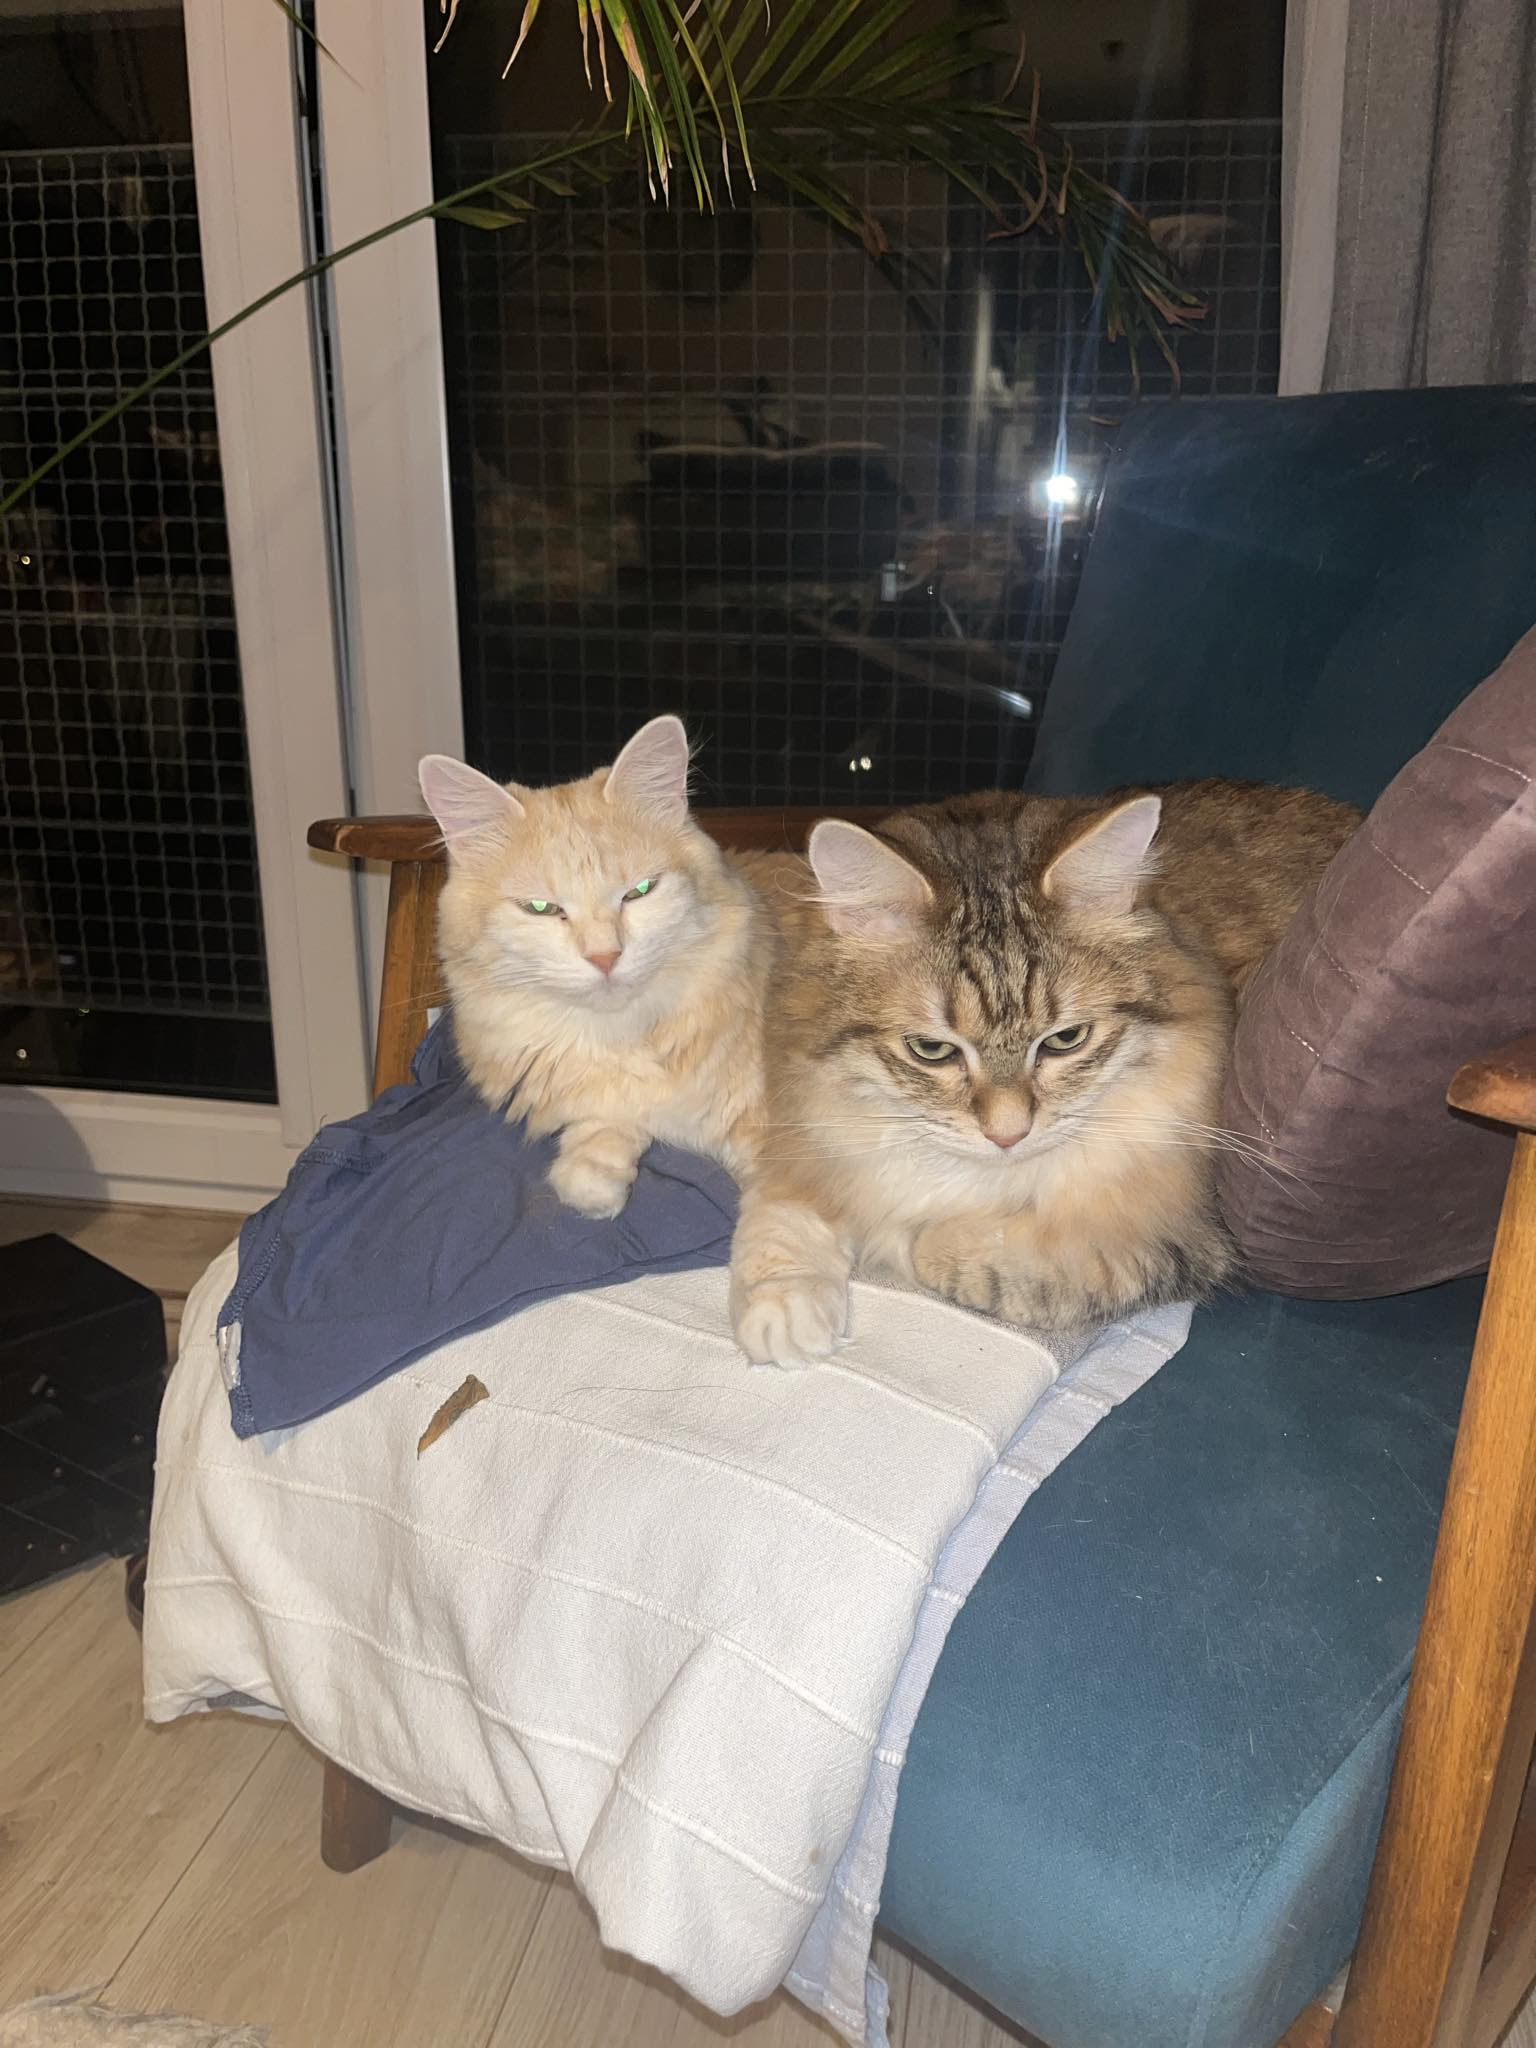

# Basic Symbolic Computations

In [1]:
#require "nomad";;
open Nomad
open Nomad.Expr
open Nomad.Eval
open Nomad.Derivatives

let x = Var "x"
let y = Var "y"
let z = Var "z"

val x : Nomad.Expr.expr = Var "x"


val y : Nomad.Expr.expr = Var "y"


val z : Nomad.Expr.expr = Var "z"


In [2]:
(* x^2 + y^3, dla x = 1, y = 2 *)
let f = (x ^: Float 2.) +: (y ^: Float 3.);;
let env: env = [("x", 1.); ("y", 2.)] in
eval env f;;

val f : Nomad.Expr.expr =
  Sum [Pow (Var "x", Float 2.); Pow (Var "y", Float 3.)]


- : float = 9.


In [3]:
derivative "x" f |> string_of_expr;;
derivative "y" f |> string_of_expr;;

nth_derivative "y" 2 f |> string_of_expr;;
nth_derivative "y" 3 f |> string_of_expr;;
nth_derivative "y" 4 f |> string_of_expr;;

- : string = "2 * x"


- : string = "3 * y^2"


- : string = "6 * y"


- : string = "6"


- : string = "0"


In [4]:
let f = x ^: Float (-.1.);;
f |> string_of_expr;;

nth_derivative "x" 1 f |> string_of_expr;;
nth_derivative "x" 2 f |> string_of_expr;;
nth_derivative "x" 3 f |> string_of_expr;;
nth_derivative "x" 4 f |> string_of_expr;;
nth_derivative "x" 5 f |> string_of_expr;;

val f : Nomad.Expr.expr = Pow (Var "x", Float (-1.))


- : string = "x^{-1}"


- : string = "-1 * x^{-2}"


- : string = "2 * x^{-3}"


- : string = "-6 * x^{-4}"


- : string = "24 * x^{-5}"


- : string = "-120 * x^{-6}"


In [5]:
(* Zadanie z AN - lista 13 zad. 3 *)
let e = Cos ((Float 3. *: x) +: (pi /: Float 4.)) in
let e' = nth_derivative "x" 4 e in
string_of_expr e';;

- : string = "81 * cos(0.785398163397 + 3 * x)"


In [6]:
(* mamy specjalne wartosci takie jak pi lub e dla wygody użytkownika *)
pi |> string_of_expr;;

- : string = "π"


# Simplify

## Algorytm upraszczania wyrażeń algebraicznych

## Uwaga
Podobną funkcjonalność zapewnia biblioteka SymPy, jednak ona jest dużo, dużo większym projektem,
gdzie samo upraszczanie z `simplify.py` (a jest więcej plików) zajmuje [2150 linii kodu](https://github.com/sympy/sympy/blob/b4ce69ad5d40e4e545614b6c76ca9b0be0b98f0b/sympy/simplify/simplify.py#L420-L760).

Z tego powodu projekt oczywiście nie zrobi wielu pięknych uproszczeń (faktoryzacja, uproszczenia trygonometryczne), ma problem z ułamkami piętrowymi (i wiele innych bolączek o których nie pomyślałem). Dlatego podejdźmy do tego jak do `Minecraft Alpha` i przymknijmy oko! :-)

## Główne komponenty algorytmu

### 1. Rekurencyjna transformacja wyrażeń
- Rekurencyjne przetwarzanie drzewa wyrażenia
- Aplikacja reguł przekształceń na każdym poziomie
- Zachowanie poprawności matematycznej transformacji

### 2. Agregacja wyrażeń
- Łączenie podobnych składników:
  $$x + 2x \rightarrow 3x$$
- Grupowanie wspólnych czynników:
  $$(a \cdot b) \cdot (a \cdot c) \rightarrow a^2 \cdot b \cdot c$$

### 3. Normalizacja kolejności
- Przestrzeganie konwencji matematycznych:
  $$2 \cdot x \text{ zamiast } x \cdot 2$$
- Uporządkowanie ułatwiające dalsze uproszczenia

### 4. Spłaszczanie wyrażeń
Eliminacja zbędnego zagnieżdżenia:
$$\prod(x, \prod(y, z)) \rightarrow \prod(x, y, z)$$
$$\sum(3, \sum(5, 7)) \rightarrow \sum(3, 5, 7)$$

### 5. Iteracyjne przetwarzanie
- Wielokrotne aplikowanie transformacji
- Przykład złożonego uproszczenia:
  $$\sin^2(x + y - x) + \cos^2(\frac{y^2}{y + 0}) = 1$$
  $$\downarrow$$
  $$\sin^2(y) + \cos^2(y) = 1$$
  $$\downarrow$$
  $$1$$

## Zalety implementacji
- Czytelny, interpretowalny kod przez śmiertelników
- Łatwa rozszerzalność o nowe reguły
- Proste AST, ułatwiające dodawania nowej funkcjonalności symbolicznych obliczeń
- Przetwarzanie złożonych wyrażeń

## Ograniczenia
- Konieczność wielokrotnego przetwarzania
- Złożoność obliczeniowa dla skomplikowanych wyrażeń
- Ograniczony zestaw wbudowanych reguł upraszczania

In [7]:
open Nomad.Simplify;;

let e = (Var "x" ^: Float 3.) in
let e2 = (Var "x" ^: Float 2.) in
simplify (e /: e2) |> string_of_expr;;

let e = Float 3. *: Var "z" /: Var "z" in
simplify e |> string_of_expr;;

- : string = "x"


- : string = "3"


In [8]:
(* kinda ugly AST *)
let f = Neg(x) +: Neg(y) +: z +: x +: y;;

(* teraz piekne*)
simplify f |> string_of_expr;; 

val f : Nomad.Expr.expr =
  Sum
   [Sum [Sum [Sum [Neg (Var "x"); Neg (Var "y")]; Var "z"]; Var "x"];
    Var "y"]


- : string = "z"


In [9]:
let g = x +: y +: z in 
let f = (Sin(g) *: Sin(g)) +: (Cos(g) *: Cos(g)) in (* sin(g)^2 + cos(g)^2 *)

simplify f;;

- : Nomad.Expr.expr = Float 1.


In [10]:
let f = ((x ^: Float 3.) *: (x ^: Float 39.) *: (x ^: Float 0.42)) +: (y ^: Float 1.23) /: (y ^: Float 0.23);;
f |> simplify |> string_of_expr;;

val f : Nomad.Expr.expr =
  Sum
   [Product
     [Product [Pow (Var "x", Float 3.); Pow (Var "x", Float 39.)];
      Pow (Var "x", Float 0.42)];
    Product
     [Pow (Var "y", Float 1.23);
      Pow (Pow (Var "y", Float 0.23), Float (-1.))]]


- : string = "x^42.42 + y"


# Numerical Optimization

### Newton

In [11]:
open Nomad.Newton;;

(* x = 2*)
let eq: equation = (x, Float 2.) in
Result.get_ok (solve_newton eq ~initial_guess:0. ~max_iter:10);;

- : float = 2.


In [12]:
(* x^2 = 2 *)
let eq: equation = (x *: x, Float 2.) in
Result.get_ok (solve_newton eq ~initial_guess:0.1 ~max_iter:10);;

- : float = 1.41421360011580322


In [13]:
(* sin(x) = cos(x) *)
let eq: equation = (Sin(x), Cos(x)) in
Result.get_ok (solve_newton eq ~initial_guess:0. ~max_iter:10);;

- : float = 0.785398175999701853


In [14]:
(* log(x) = 1 *)
let eq: equation = (Log(x), Float 1.) in
Result.get_ok (solve_newton eq ~initial_guess:0.1 ~max_iter:10);;

- : float = 2.71828177920980218


In [15]:
(* x^2 / y^1.5 = 18 *)
let eq: equation = ((x^:Float 2.) /: (y ^: Float 1.5), Float 18.) in
let initial_guess = [("x", 2.); ("y", 0.5)] in
let result = Result.get_ok (solve_newton_multivar eq ~initial_guess ~max_iter:100) in

let x, y = get_value "x" result, get_value "y" result in
print_endline ("x = " ^ string_of_float x);
print_endline ("y = " ^ string_of_float y);
((x *. x) /. (Float.pow y 1.5));;

x = 2.04713833988
y = 0.378455295125


- : float = 18.0000000000356586


### Bisection

In [16]:
open Nomad.Bisection;;

(* x^2 = 2 *)
let eq: equation = (x ^: Float 2., Float 2.) in
Result.get_ok (solve_bisection eq ~a:0. ~b:2. ~tolerance:0.00001 ~max_iter:20);;

- : float = 1.414215087890625


### Gradient descent

In [17]:
open Nomad.Gradient_descent;;

(* x + y + z = 2*)
let eq: equation = (x +: y +: z, Float 2.) in
let initial_guess: env = [("x", -1.); ("y", 21.); ("z", 100.)] in
let result = Result.get_ok (solve_gradient_descent eq ~initial_guess ~learning_rate:0.1 ~max_iter:100) in

let x, y, z = get_value "x" result, get_value "y" result, get_value "z" result in
print_endline ("x = " ^ string_of_float x);
print_endline ("y = " ^ string_of_float y);
print_endline ("z = " ^ string_of_float z);
x +. y +. z;;

x = -40.3333333333
y = -18.3333333333
z = 60.6666666667


- : float = 2.00000000000000711


In [18]:
(* x*y + x^2 + y^2 = 8 *)
let eq: equation = ((x *: y) +: (x *: x) +: (y *: y), Float 8.) in
let initial_guess: env = [("x", 1.); ("y", 0.)] in
let result = Result.get_ok (solve_gradient_descent eq ~initial_guess ~learning_rate:0.01 ~max_iter:100) in

let x, y = get_value "x" result, get_value "y" result in
print_endline ("x = " ^ string_of_float x);
print_endline ("y = " ^ string_of_float y);
((x *. y) +. (x *. x) +. (y *. y));;

x = 2.3324288043
y = 0.813642134236


- : float = 8.


# Numerical Optimization Comparison

In [35]:
open Nomad.Expr
open Nomad.Eval
open Nomad.Gradient_descent
open Nomad.Newton

let x, y = Var "x", Var "y"


(* https://en.wikipedia.org/wiki/Himmelblau's_function *)
let himmelblau = (x ^: Float 2. +: y -: Float 11.) ^: Float 2. +: 
                 (x +: y ^: Float 2. -: Float 7.) ^: Float 2.

(* https://en.wikipedia.org/wiki/Rosenbrock_function *)
let rosenbrock = (Float 100. *: (y -: x ^: Float 2.) ^: Float 2.) +: 
                 (Float 1. -: x) ^: Float 2.

let print_header name = 
  Printf.printf "\n%s\n%s\n" name (String.make 50 '=')

let compare_methods expr name start_points =
  print_header name;
  Printf.printf "Function: %s\n\n" (string_of_expr expr);

  List.iteri (fun i (x0, y0) ->
    Printf.printf "Starting point %d: (%f, %f)\n" (i + 1) x0 y0;
    
    (* Try gradient descent *)
    Printf.printf "\nGradient Descent:\n";
    (match gradient_descent 
      ~expr 
      ~env:[("x", x0); ("y", y0)]
      ~learning_rate:0.01 
      ~max_iter:1000 with
    | Ok env -> 
        let final_x = get_value "x" env in
        let final_y = get_value "y" env in
        let value = eval env expr in
        Printf.printf "✓ Converged to (%f, %f) with value %f\n" 
          final_x final_y value
    | Error _ -> 
        Printf.printf "✗ Failed: %s\n" "No convergence");

    (* Try Newton's method *)
    Printf.printf "\nNewton's Method:\n";
    (match solve_newton_multivar 
      (expr, Float 0.) 
      ~initial_guess:[("x", x0); ("y", y0)]
      ~max_iter:100 with
    | Ok env ->
        let final_x = get_value "x" env in
        let final_y = get_value "y" env in
        let value = eval env expr in
        Printf.printf "✓ Converged to (%f, %f) with value %f\n" 
          final_x final_y value
    | Error _ ->
        Printf.printf "✗ Failed: %s\n" "No convergence");
    
    print_newline ()
  ) start_points

let () =
  let himmelblau_points = [
    (1.0, 1.0);
    (-2.0, 2.0);
    (3.0, -3.0)
  ] in

  let rosenbrock_points = [
    (0.0, 0.0);
    (-1.0, 1.0);
    (2.0, 4.0)
  ] in

  compare_methods himmelblau "Himmelblau Function" himmelblau_points;
  compare_methods rosenbrock "Rosenbrock Function" rosenbrock_points

val x : Nomad.Expr.expr = Var "x"
val y : Nomad.Expr.expr = Var "y"


val himmelblau : Nomad.Expr.expr =
  Pow (Pow (Var "x", Sum [Sum [Float 2.; Var "y"]; Neg (Float 11.)]),
   Pow
    (Sum
      [Float 2.;
       Pow (Sum [Var "x"; Var "y"], Sum [Float 2.; Neg (Float 7.)])],
    Float 2.))


val rosenbrock : Nomad.Expr.expr =
  Pow
   (Sum
     [Pow
       (Product [Float 100.; Pow (Sum [Var "y"; Neg (Var "x")], Float 2.)],
       Float 2.);
      Sum [Float 1.; Neg (Var "x")]],
   Float 2.)


val print_header : string -> unit = <fun>


val compare_methods :
  Nomad.Expr.expr -> string -> (float * float) list -> unit = <fun>



Himmelblau Function
Function: x^{2 + y - 11}^{(2 + (x + y)^{2 - 7})^2}

Starting point 1: (1.000000, 1.000000)

Gradient Descent:
✓ Converged to (1.348398, 1.000000) with value 0.000061

Newton's Method:
✓ Converged to (1.573184, 1.000000) with value 0.000000

Starting point 2: (-2.000000, 2.000000)

Gradient Descent:
✓ Converged to (nan, 2.000000) with value nan

Newton's Method:
✓ Converged to (-2.000000, 2.000000) with value 0.000000

Starting point 3: (3.000000, -3.000000)

Gradient Descent:
✓ Converged to (nan, -3.000000) with value nan

Newton's Method:
✓ Converged to (3.000000, -3.000000) with value 0.000000


Rosenbrock Function
Function: ((100 * (y - x)^2)^2 + 1 - x)^2

Starting point 1: (0.000000, 0.000000)

Gradient Descent:
✓ Converged to (1.002858, 0.979650) with value 0.000000

Newton's Method:
✓ Converged to (1.002301, 0.979053) with value 0.000000

Starting point 2: (-1.000000, 1.000000)

Gradient Descent:
✓ Converged to (nan, nan) with value nan

Newton's Method:
✗ Fa

# Taylor Visualisation

In [ ]:
open Nomad.Expr
open Nomad.Eval
open Nomad.Derivatives
open Nomad.Simplify

let x = Var "x"

let factorial n =
  let rec aux acc n =
    if n = 0 then acc else aux (acc * n) (n - 1)
  in
  aux 1 n

(* Compute nth term of Taylor series *)
let taylor_term f x0 n =
  let nth_der = nth_derivative "x" n f in
  let coeff = eval [("x", x0)] nth_der in
  let numerator = Float coeff *: (x -: Float x0) ^: Float (float_of_int n) in
  let denominator = Float (float_of_int (factorial n)) in
  numerator /: denominator

(* Generate Taylor series up to degree n *)
let taylor_series f x0 n =
  let terms = List.init (n+1) (taylor_term f x0) in
  List.fold_left (+:) (Float 0.) terms

(* ASCII plot helper *)
let plot f1 f2 ~x_min ~x_max ~points =
  let height = 20 in
  let width = 60 in
  let chars = [|" "; "·"; "•"; "*"; "#"|] in
  let grid = Array.make_matrix height width " " in
  
  (* Sample points *)
  let dx = (x_max -. x_min) /. float_of_int points in
  let samples1 = List.init points (fun i ->
    let x = x_min +. dx *. float_of_int i in
    (x, eval [("x", x)] f1)) in
  let samples2 = List.init points (fun i ->
    let x = x_min +. dx *. float_of_int i in
    (x, eval [("x", x)] f2)) in
    
  (* Scale to plot *)
  let y_vals = List.map snd samples1 @ List.map snd samples2 in
  let y_min = List.fold_left min max_float y_vals in
  let y_max = List.fold_left max min_float y_vals in
  let scale_y y = int_of_float ((y -. y_min) /. (y_max -. y_min) *. float_of_int (height-1)) in
  
  (* Plot points *)
  List.iter (fun (x, y) ->
    let i = int_of_float ((x -. x_min) /. (x_max -. x_min) *. float_of_int (width-1)) in
    let j = scale_y y in
    grid.(height-1-j).(i) <- chars.(2)
  ) samples1;
  
  List.iter (fun (x, y) ->
    let i = int_of_float ((x -. x_min) /. (x_max -. x_min) *. float_of_int (width-1)) in
    let j = scale_y y in
    if grid.(height-1-j).(i) = chars.(2) then
      grid.(height-1-j).(i) <- chars.(4)
    else
      grid.(height-1-j).(i) <- chars.(3)
  ) samples2;
  
  (* Print plot *)
  Array.iter (fun row ->
    Array.iter print_string row;
    print_newline ()
  ) grid

let analyze_taylor_series f name x0 degree x_range =
  Printf.printf "\n=== Taylor Series Analysis for %s around x₀=%.1f ===\n" name x0;
  
  let taylor = taylor_series f x0 degree in
  Printf.printf "\nOriginal: %s\n" (string_of_expr f);
  Printf.printf "Taylor approximation (n=%d): %s\n" degree (string_of_expr (simplify taylor));
  
  Printf.printf "\nPlot Legend:\n";
  Printf.printf "  • Original function\n";
  Printf.printf "  * Taylor approximation\n";
  Printf.printf "  # Points where they overlap\n\n";
  
  plot f taylor ~x_min:(fst x_range) ~x_max:(snd x_range) ~points:60

let () =
  (* Test cases *)
  let test_functions = [
    (Sin x, "sin(x)", 0., (-2., 2.));
    (Exp x, "exp(x)", 0., (-2., 2.));
    (Log (x +: Float 1.), "log(1+x)", 0., (-0.5, 2.));
  ] in
  
  List.iter (fun (f, name, x0, range) ->
    analyze_taylor_series f name x0 10 range
  ) test_functions

val x : Nomad.Expr.expr = Var "x"


val factorial : int -> int = <fun>


val taylor_term : Nomad.Expr.expr -> float -> int -> Nomad.Expr.expr = <fun>


val taylor_series : Nomad.Expr.expr -> float -> int -> Nomad.Expr.expr =
  <fun>


val plot :
  Nomad.Expr.expr ->
  Nomad.Expr.expr -> x_min:float -> x_max:float -> points:int -> unit = <fun>


val analyze_taylor_series :
  Nomad.Expr.expr -> string -> float -> int -> float * float -> unit = <fun>



=== Taylor Series Analysis for sin(x) around x₀=0.0 ===

Original: sin(x)
Taylor approximation (n=10): 1 + x + -0.166666666667 * x^3 + -0.000198412698413 * x^7 + 2.7557319224e-06 * x^9 + 0.00833333333333 * x^5

Plot Legend:
  • Original function
  * Taylor approximation
  # Points where they overlap

                                                     *      
                                             ******** ***** 
                                         ****               
                                      ***                   
                                   ***                      
                                 **                         
                              ***                           
                            **                ••••••••••••• 
                          **              ••••              
                       ***             •••                  
                    ***             •••                     
                 ***      

# Co by się przydało?

## 1. Lepsze wyświetlanie stringów - w szczególności ułamków? Pracuję nad tym.
## 2. Parser, bo niewygodnie się wklepuje wyrażenia / równania.

# Art Generator 

In [20]:
open Nomad.Expr
open Nomad.Eval

(* ANSI color helpers *)
let rgb r g b = Printf.sprintf "\027[38;2;%d;%d;%dm" r g b
let reset = "\027[0m"

(* Art patterns *)
let wave_pattern x y = 
  let expr = 
    Sin (x *: Float 0.3) *: 
    Cos (y *: Float 0.2) +: 
    Sin ((x +: y) *: Float 0.4)
  in expr

let spiral_pattern x y =
  let expr =
    Sin ((x ^: Float 2. +: y ^: Float 2.) ^: Float 0.5) *:
    Exp (Float (-0.1) *: (x ^: Float 2. +: y ^: Float 2.))
  in expr

let interference_pattern x y =
  let expr =
    Sin (x *: Float 2.) *: 
    Sin (y *: Float 2.) +:
    Sin ((x -: y) *: Float 3.)
  in expr

(* Visualization *)
let draw_pattern pattern ~width ~height =
  let x = Var "x" in
  let y = Var "y" in
  
  (* Scale coordinates to make patterns look nice *)
  let scale = 10.0 in
  let to_coord i max = 
    (float_of_int i -. float_of_int max /. 2.) *. scale /. float_of_int max
  in

  for j = 0 to height - 1 do
    for i = 0 to width - 1 do
      let x_val = to_coord i width in
      let y_val = to_coord j height in
      
      let value = eval [("x", x_val); ("y", y_val)] (pattern x y) in
      let normalized = (value +. 1.) /. 2. in  (* Map [-1,1] to [0,1] *)
      
      (* Create color gradient *)
      let r = int_of_float (normalized *. 255.) in
      let g = int_of_float ((1. -. normalized) *. 255.) in
      let b = int_of_float (sin (normalized *. 3.14) *. 255.) in
      
      Printf.printf "%s▀%s" (rgb r g b) reset
    done;
    print_newline ()
  done;
  print_newline ()

(* Generate art *)
let generate_art () =
  Printf.printf "\nMathematical Art Gallery\n\n";
  
  Printf.printf "Wave Pattern:\n";
  draw_pattern wave_pattern ~width:60 ~height:20;
  Unix.sleep 1;
  
  Printf.printf "Spiral Pattern:\n";
  draw_pattern spiral_pattern ~width:60 ~height:20;
  Unix.sleep 1;
  
  Printf.printf "Interference Pattern:\n";
  draw_pattern interference_pattern ~width:60 ~height:20

let () = generate_art ()

val rgb : int -> int -> int -> string = <fun>


val reset : string = "\027"


val wave_pattern : Nomad.Expr.expr -> Nomad.Expr.expr -> Nomad.Expr.expr =
  <fun>


val spiral_pattern : Nomad.Expr.expr -> Nomad.Expr.expr -> Nomad.Expr.expr =
  <fun>


val interference_pattern :
  Nomad.Expr.expr -> Nomad.Expr.expr -> Nomad.Expr.expr = <fun>


val draw_pattern :
  (Nomad.Expr.expr -> Nomad.Expr.expr -> Nomad.Expr.expr) ->
  width:int -> height:int -> unit = <fun>


val generate_art : unit -> unit = <fun>



Mathematical Art Gallery

Wave Pattern:
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀[38;2;0;255;-1m▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀[38;2;-2;257;-8m▀[38;2;-5;260;-18m▀[38;2;-8;263;-27m▀[38;2;-11;266;-34m▀[38;2;-12;267;-40m▀[38;2;-14;269;-44m▀[38;2;-14;269;-46m▀[38;2;-15;270;-47m▀[38;2;-14;269;-45m▀[38;2;-13;268;-42m▀[38;2;-12;267;-37m▀[38;2;-9;264;-31m▀[38;2;-7;262;-22m▀[38;2;-3;258;-12m▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀[38;2;257;-2;-7m▀
▀▀▀▀▀▀▀▀▀▀[38;2;-5;260;-16m▀[38;2;-10;265;-31m▀[38;2;-14;269;-45m▀[38;2;-18;273;-57m▀[38;2;-22;277;-68m▀[38;2;-25;280;-77m▀[38;2;-27;282;-84m▀[38;2;-29;284;-90m▀[38;2;-30;285;-93m▀[38;2;-31;286;-95m▀[38;2;-31;286;-96m▀[38;2;-30;285;-94m▀[38;2;-29;284;-91m▀[38;2;-27;282;-85m▀[38;2;-25;280;-78m▀[38;2;-22;277;-69m▀[38;2;-18;273;-58m▀[38;2;-14;269;-45m▀[38;2;-9;264;-30m▀[38;2;-4;259;-13m▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀[38;2;263;-8;-25m▀[38;2;272;-17;-53m▀[38;2;280;-